# Down sampling과 Up sampling
- Down sampling
    - Convolution을 진행하면서 입력 이미지의 크기를 줄여가는 것
    - convolution의 stride나 Pooling layer를 이용해 줄인다.
- Up sampling
    - Convolution을 진행하면서 입력 이미지의 크기를 늘려가는 것
    - 보통 convolution의 stride나 Pooling layer를 이용해 줄여진 이미지를 다시 원래 크기로 복원 시킬때 사용된다.

# UpSampling
- tensorflow.keras.layers.UpSampling2D 사용.
- 단순히 늘린다.
    - 크기를 늘리는 resizing을 한 뒤 빈 공간을 보간법을 사용해 채운다.
- 사이즈를 키워가며 학습할 경우 UpSampling2D + Conv2D 를 연결하여 UpSampling2D로 입력 이미지의 사이즈를 늘린 뒤 Conv2D를 연결해서 학습이 되도록 한다.
- 하이퍼파라미터
    - size=(2,2) : 입력을 몇배로 크게 만들지 지정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
X = np.arange(1, 5).reshape(1, 2, 2, 1)
X.shape

In [ ]:
# interpolation='nearest' : default, 'bilinear' 두가지 방식 제공
model = keras.Sequential()
model.add(layers.UpSampling2D(size=2, input_shape=(2,2,1)))
# model.add(layers.UpSampling2D(size=5, interpolation='bilinear', input_shape=(2,2,1)))
model.summary()

In [ ]:
X_up = model.predict(X)
X_up.shape, X.shape

In [ ]:
X_up.squeeze()

##  Transpose Convolution
- tensorflow.keras.layers.Conv2DTranspose 를 이용
- parameter가 있는 Filter를 이용해 입력 이미지의 사이즈를 늘린다.
    - convolution 계산을 역으로 하는 방식을 사용한다.
- padding을 same으로 하고 strides로 크기를 정한다.
    - size가 strides로 지정한 배수 만큼 늘어난다.


In [ ]:
model = keras.Sequential()
model.add(layers.Conv2DTranspose(kernel_size=3, filters=12, strides=2, padding='same', input_shape=(2,2,1)))

In [ ]:
X_up2 = model.predict(X)
X.shape, X_up2.shape

In [ ]:
X_up2[0]

# DCGAN

- Deep Convolutional Network + GAN
- 처음 GAN 모델은 Dense Layer를 사용했는데 이것을 Convolution Layer로 변경함.

## DCGAN의 안정적 학습을 위한 가이드라인
1. Convolution 레이어에 Pooling Layer를 사용하지 않는다.
2. 안정적 학습을 위해 BatchNormalization 사용.
3. Fully Connected Layer (Dense) 를 사용하지 않는다. (Discriminator의 출력은 예외)
4. Generator의 Hidden Layer에는 LeakyReLU activation을 사용하고 출력 Layer는 Tanh를 사용.
5. Discriminator의 모든 Layer는 LeakyReLU activation을 사용한다. (Discriminator의 출력은 예외)

In [ ]:
# 생성할 대상 학습 데이터셋: fashion mnist dataset => (28, 28, 1)
img_shape = (28, 28, 1)  # 판별자의 input shape
z_dim = 100  # 생성자에 입력할 잡음(Latent space/vector)  vector 크기  (100, ) --생성자---> (28, 28, 1)

# 생성자
- 이미지 upsampling
    - 7X7 => 14X14 => 28X28 로 키운다.
    - Transpose Convolution 사용
        - Conv2DTranspose

In [ ]:
def create_generator(z_dim=100):
    model = keras.Sequential()

    model.add(layers.Dense(7*7*256, input_shape=(z_dim, )))
    model.add(layers.Reshape((7, 7, 256)))

#     image size는 두배씩 늘리고 channel은 두배씩 줄인다.
    # Convolution block : Conv2DTranspose -> BatchNormalization -> Activation(LeakyReLU)
    model.add(layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.01))

    # 채널만 절반으로 줄임.
    model.add(layers.Conv2DTranspose(filters=64, kernel_size=3, strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.01))

    # size는 두배로 늘림. 14 X 14 => 28 X 28, channle: 1 (grayscale)
    model.add(layers.Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same'))
    model.add(layers.Activation("tanh"))  # Outputlayer의 activation함수로 tanh를 지정하여 각 pixcel의 값을 -1 ~ 1 범위의 값으로 출력한다.

    return model

# 판별자
- 진짜인지 여부를 판별하는 이진분류 모델
- 28 X 28 input => 14 X 14 => 7 X 7 => 3 X 3으로 절반씩 down sampling

In [ ]:
def create_discriminator(img_shape):
    model = keras.Sequential()

    # pooling layer를 사용하지 않고 stride를 이용해서 size를 줄인다.
    # size를 절반씩 줄여나간다. filter(channel)는 32->64->128 늘린다.
    model.add(layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same',
                            input_shape=img_shape))
    model.add(layers.LeakyReLU(alpha=0.01))

    model.add(layers.Conv2D(filters=64, kernel_size=3, strides=2,padding='same'))
    model.add(layers.LeakyReLU(alpha=0.01))

    model.add(layers.Conv2D(filters=128, kernel_size=3, strides=2,padding='same'))
    model.add(layers.LeakyReLU(alpha=0.01))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))  # 출력: 이진분류 - 0:fake, 1:real

    return model

# GAN 모델
- 생성자 + 판별자

In [ ]:
# 목적: 생성자를 학습시키는 것.
def create_gan(generator, discriminator):
    model = keras.Sequential()
    model.add(generator)
    model.add(discriminator)

    return model

# 모델 생성 및 컴파일

In [ ]:
# 판별자 생성 + 컴파일
discriminator = create_discriminator(img_shape) #(28, 28, 1)
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 생성자 생성
generator = create_generator(z_dim)

discriminator.trainable=False  # GAN 모델의 discriminator(layer)를 Frozen(학습할때 weight가 update되지 않게함.)
# GAN 모델 생성
gan = create_gan(generator, discriminator)
gan.compile(optimizer='adam', loss='binary_crossentropy')

# 훈련

### 이미지 생성 함수
- Generator를 이용해 가짜 이미지를 생성해 출력하는 함수

In [ ]:
import matplotlib.pyplot as plt
def sample_images(generator, image_grid_row=4, image_grid_col=4):
    """
    Generator를 이용해 가짜 이미지를 생성해 출력하는 함수.
    그리드 행, 열의 개수를 받아 행 * 열 개수만큼 그린다.
    [매개변수]
        generator: Generator 모델
        image_grid_rows: 이미지를 그릴 grid 행수 (기본값 : 4)
        image_grid_columns: 이미지를 그릴 grid 열수(기본값 : 4)
    """
    z = np.random.normal(0, 1, (image_grid_row*image_grid_col, z_dim))
    gen_images = generator.predict(z)
    plt.figure(figsize=(7,7))
    for i in range(image_grid_row * image_grid_col):
        plt.subplot(image_grid_row, image_grid_col, i+1)
        plt.imshow(gen_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()

In [ ]:
sample_images(generator)

## training 함수

In [ ]:
loss_list = []
acc_list = []
iteration_list = []

def train(train_image, iterations, batch_size, sample_interval):
    """
    [parameter]
        train_image: 진짜 이미지데이터셋
        iterations : 총 step수
        batch_size : batch size
        sample_interval: 몇 iteration당 한번씩 훈련결과를 출력/저장할지 간격
    """

    train_image = train_image/127.5-1 # -1 ~ 1사이로 scaling   # 전처리
    train_image = train_image[..., np.newaxis] #채널 차원 증가. (28, 28) => (28, 28, 1)

    # Label 생성: fake-0, real: 1
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    # 학습.
    for iteration in range(iterations):
        #################################### 판별자 훈련
        # 정답에서 추출할 이미지의 index를 random 함수를 이용해 batch 개수만큼 조회
        idx = np.random.randint(0, train_image.shape[0], batch_size)
        # 학습에 사용할 정답 이미지들 조회
        real_imgs = train_image[idx]

        # Fake image를 만들기 위해 generator에 넣어줄 잡음 생성.
        z = np.random.normal(0,1, (batch_size, 100))
        # Generator를 이용해 Fake image 생성
        gen_imgs = generator.predict(z)

        #진짜 이미지로 학습
        d_loss_acc_real = discriminator.train_on_batch(real_imgs, real)  # 한 스텝 학습시키는 메소드. 결과 (loss, accuracy)
        #생성자가 만든 가짜 이미지로 학습
        d_loss_acc_fake = discriminator.train_on_batch(gen_imgs, fake)

        d_loss, acc = np.add(d_loss_acc_real, d_loss_acc_fake)*0.5  # 진짜, 가짜 이미지로 학습한 결과 평균을 d_loss, acc 변수에 저장.

        ####################################생성자 훈련 - gan을 이용해서 훈련.
        z = np.random.normal(0, 1, (batch_size, 100))
        gan_loss = gan.train_on_batch(z, real) # input으로 잡음과 정답을 전달

        # 중간결과 확인
        if iteration % sample_interval == 0:
            loss_list.append((d_loss, gan_loss))
            acc_list.append(acc)
            iteration_list.append(iteration)
            print(f'{iteration} == 판별자 손실:{d_loss}, 판별자정확도:{acc}, gan(생성자)  손실:{gan_loss}')
            sample_images(generator)

4/4 [==============================] - 0s 27ms/step
0 == 판별자 손실:0.6842381060123444, 판별자정확도:0.5, gan(생성자)  손실:0.5510965585708618
1/1 [==============================] - 0s 20ms/step


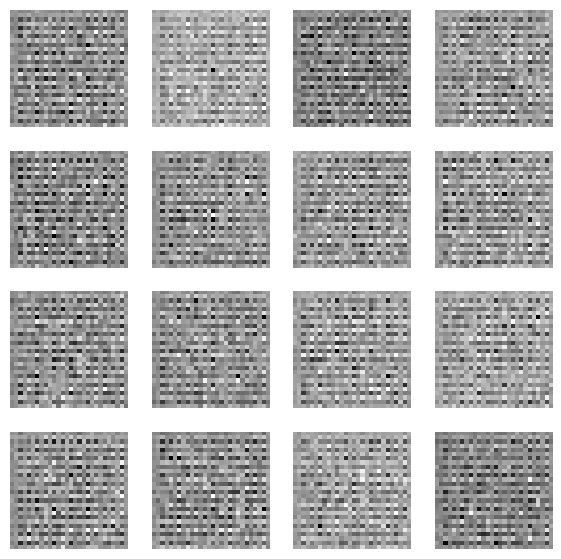

4/4 [==============================] - 0s 2ms/step
500 == 판별자 손실:0.24638061225414276, 판별자정확도:0.945000022649765, gan(생성자)  손실:1.6078124046325684
1/1 [==============================] - 0s 19ms/step


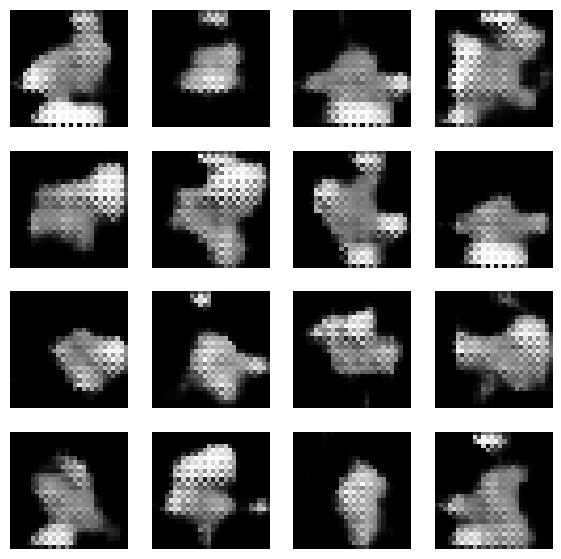

4/4 [==============================] - 0s 2ms/step
1000 == 판별자 손실:0.13458437472581863, 판별자정확도:0.9749999940395355, gan(생성자)  손실:1.6518672704696655
1/1 [==============================] - 0s 19ms/step


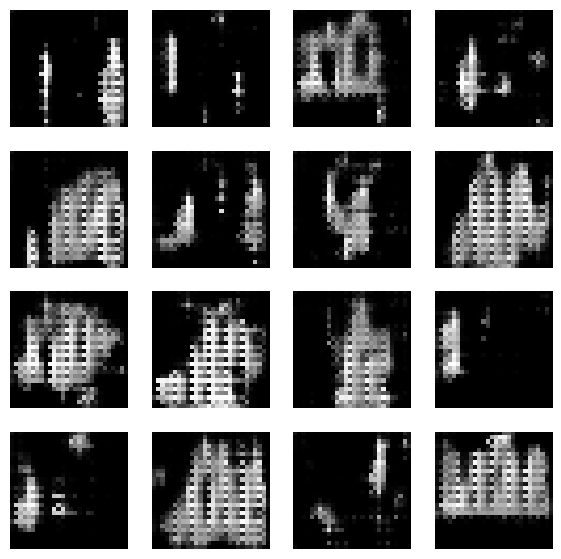

4/4 [==============================] - 0s 2ms/step
1500 == 판별자 손실:0.1937396600842476, 판별자정확도:0.9350000023841858, gan(생성자)  손실:2.6370861530303955
1/1 [==============================] - 0s 21ms/step


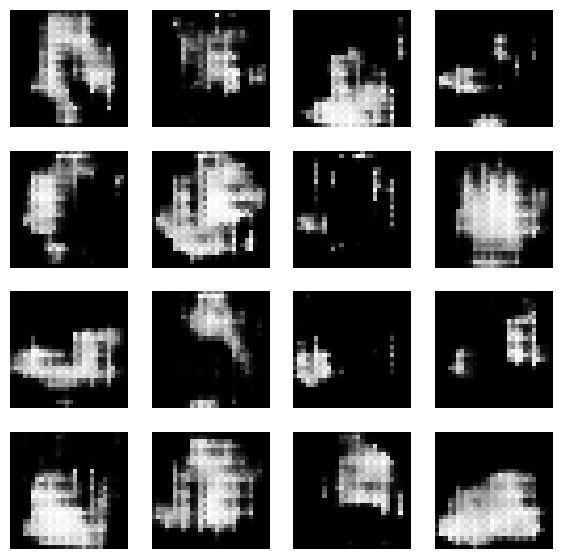

4/4 [==============================] - 0s 2ms/step
2000 == 판별자 손실:0.2462419793009758, 판별자정확도:0.8950000107288361, gan(생성자)  손실:2.6193687915802
1/1 [==============================] - 0s 19ms/step


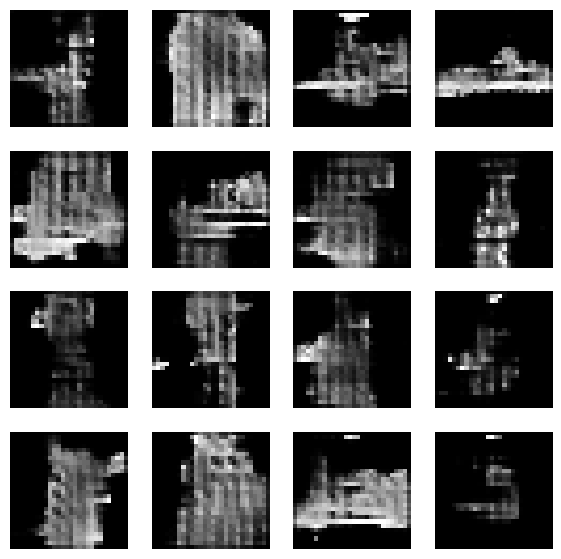

4/4 [==============================] - 0s 2ms/step
2500 == 판별자 손실:0.17529375851154327, 판별자정확도:0.9399999976158142, gan(생성자)  손실:2.5124616622924805
1/1 [==============================] - 0s 20ms/step


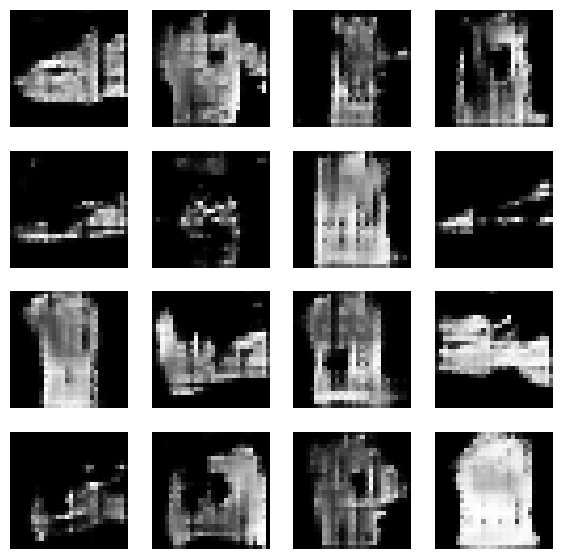

4/4 [==============================] - 0s 2ms/step
3000 == 판별자 손실:0.24859809130430222, 판별자정확도:0.9099999964237213, gan(생성자)  손실:2.115109920501709
1/1 [==============================] - 0s 20ms/step


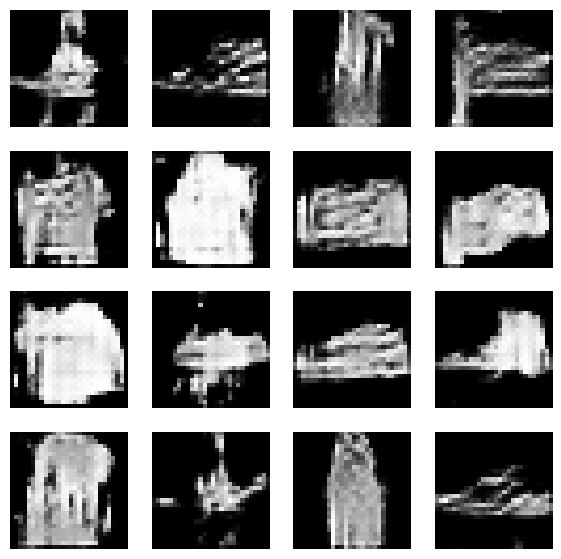

4/4 [==============================] - 0s 2ms/step
3500 == 판별자 손실:0.411574050784111, 판별자정확도:0.8300000131130219, gan(생성자)  손실:2.189586877822876
1/1 [==============================] - 0s 21ms/step


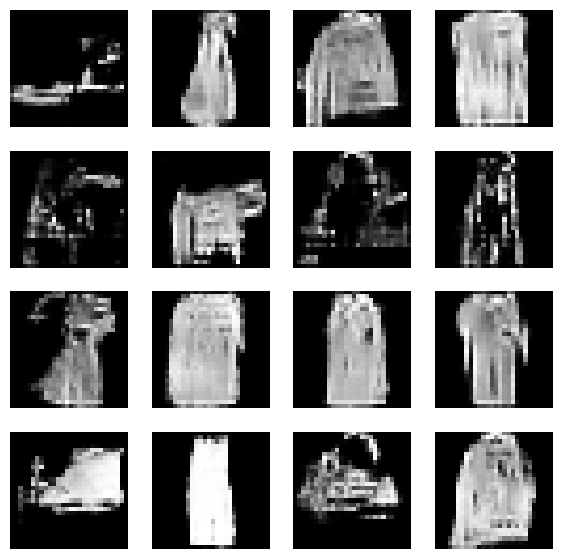

4/4 [==============================] - 0s 2ms/step
4000 == 판별자 손실:0.3138829171657562, 판별자정확도:0.8849999904632568, gan(생성자)  손실:2.7715370655059814
1/1 [==============================] - 0s 20ms/step


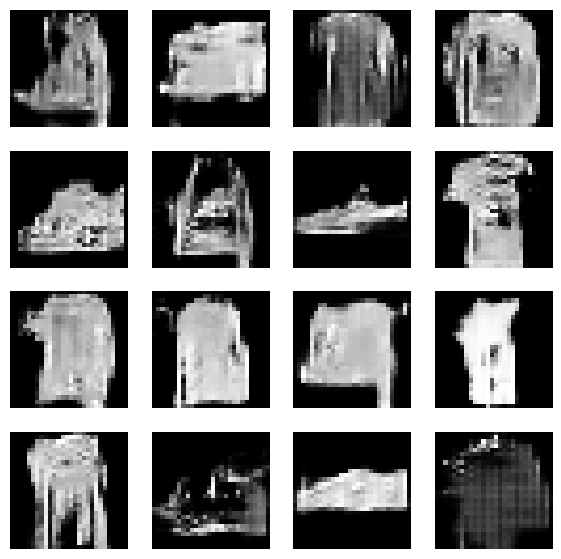

4/4 [==============================] - 0s 2ms/step
4500 == 판별자 손실:0.30379801988601685, 판별자정확도:0.875, gan(생성자)  손실:2.6341793537139893
1/1 [==============================] - 0s 22ms/step


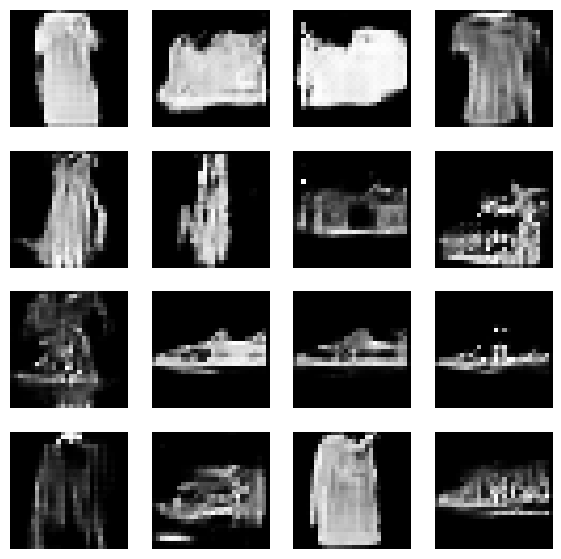

4/4 [==============================] - 0s 2ms/step
5000 == 판별자 손실:0.24950293451547623, 판별자정확도:0.9149999916553497, gan(생성자)  손실:2.3016176223754883
1/1 [==============================] - 0s 20ms/step


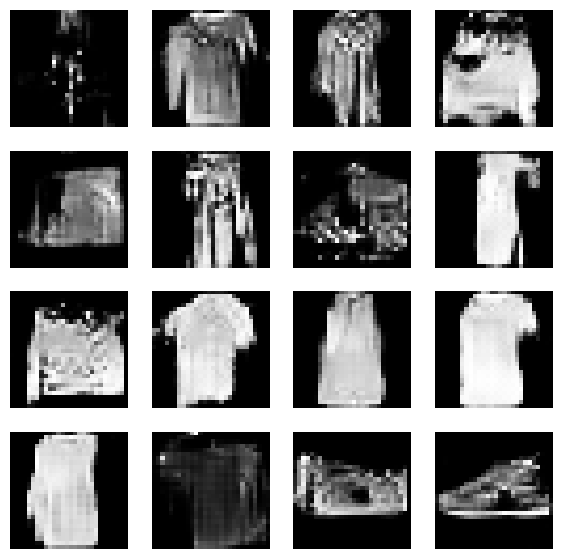

4/4 [==============================] - 0s 2ms/step
5500 == 판별자 손실:0.2790434658527374, 판별자정확도:0.8799999952316284, gan(생성자)  손실:2.2240347862243652
1/1 [==============================] - 0s 20ms/step


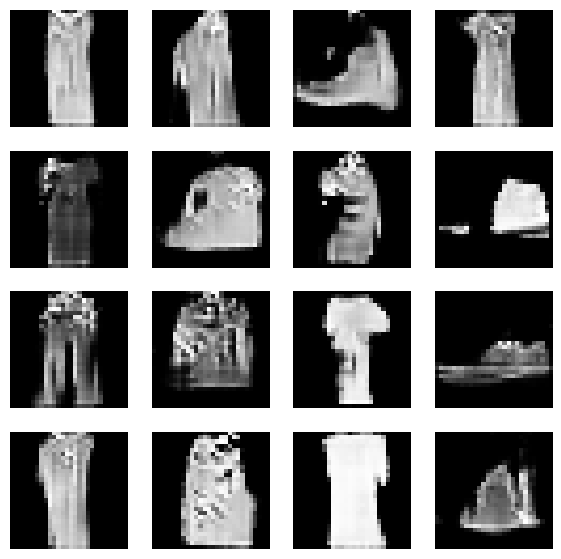

4/4 [==============================] - 0s 2ms/step
6000 == 판별자 손실:0.3032482862472534, 판별자정확도:0.875, gan(생성자)  손실:2.0442378520965576
1/1 [==============================] - 0s 20ms/step


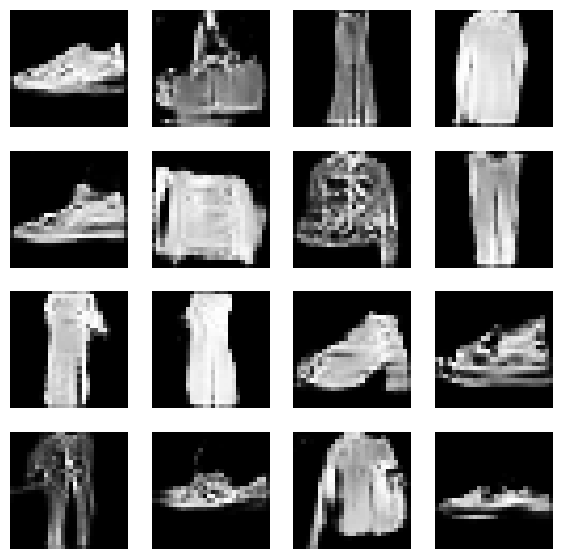

4/4 [==============================] - 0s 2ms/step
6500 == 판별자 손실:0.20163632929325104, 판별자정확도:0.9400000274181366, gan(생성자)  손실:2.547146797180176
1/1 [==============================] - 0s 21ms/step


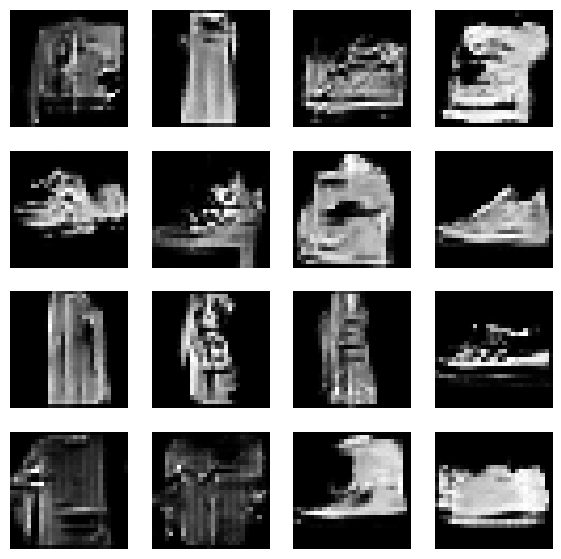

4/4 [==============================] - 0s 2ms/step
7000 == 판별자 손실:0.24682683497667313, 판별자정확도:0.8950000107288361, gan(생성자)  손실:2.862987995147705
1/1 [==============================] - 0s 27ms/step


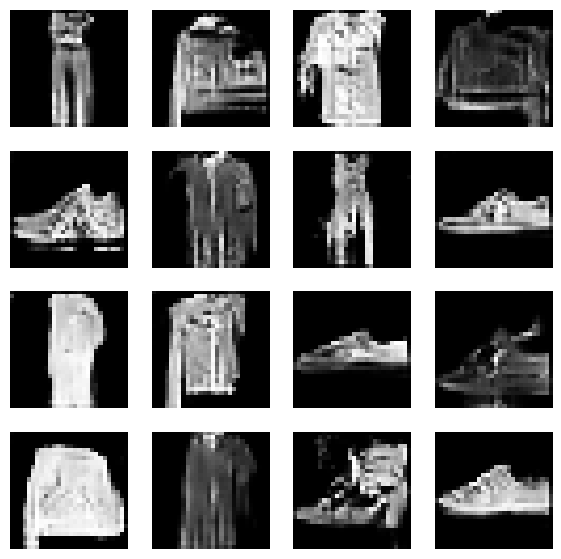

4/4 [==============================] - 0s 2ms/step
7500 == 판별자 손실:0.31351056694984436, 판별자정확도:0.8449999988079071, gan(생성자)  손실:2.0704152584075928
1/1 [==============================] - 0s 20ms/step


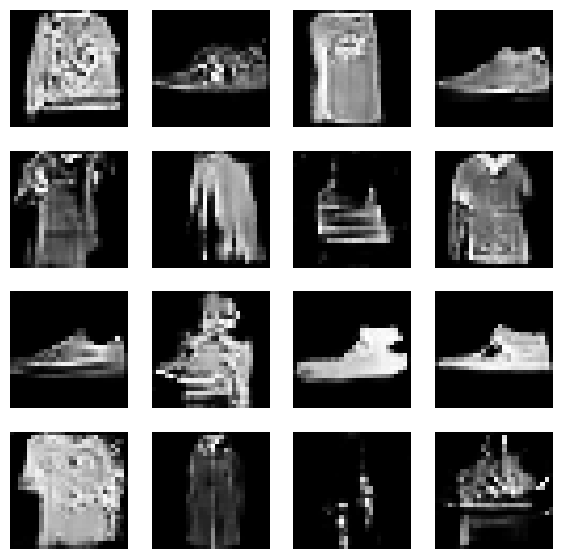

4/4 [==============================] - 0s 2ms/step
8000 == 판별자 손실:0.2455737292766571, 판별자정확도:0.8950000107288361, gan(생성자)  손실:1.5689263343811035
1/1 [==============================] - 0s 20ms/step


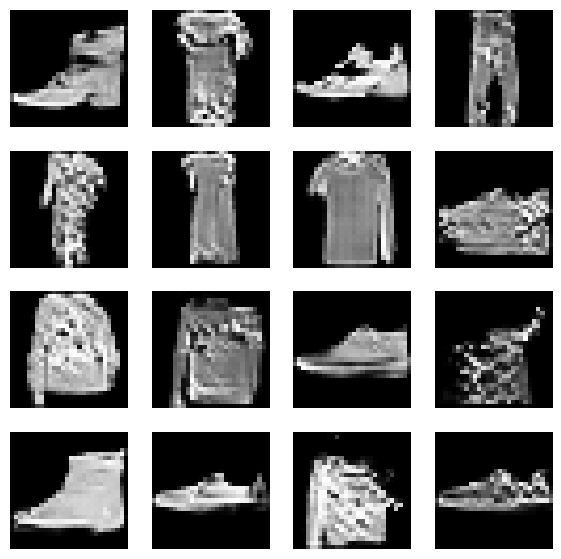

4/4 [==============================] - 0s 2ms/step
8500 == 판별자 손실:0.27207237482070923, 판별자정확도:0.8950000107288361, gan(생성자)  손실:1.9092494249343872
1/1 [==============================] - 0s 19ms/step


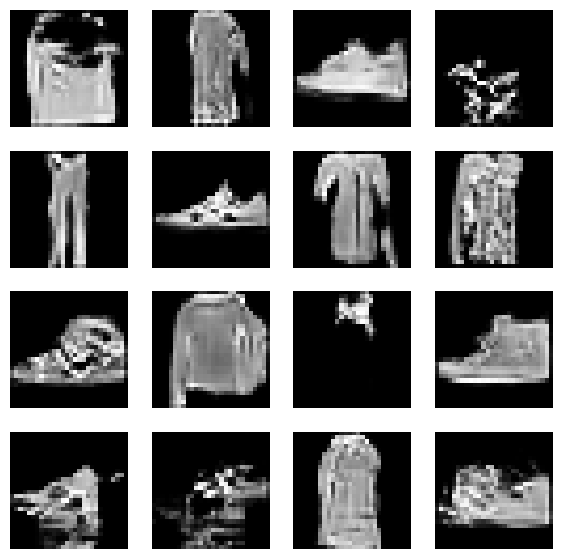

4/4 [==============================] - 0s 2ms/step
9000 == 판별자 손실:0.36570850014686584, 판별자정확도:0.7950000166893005, gan(생성자)  손실:2.0569815635681152
1/1 [==============================] - 0s 23ms/step


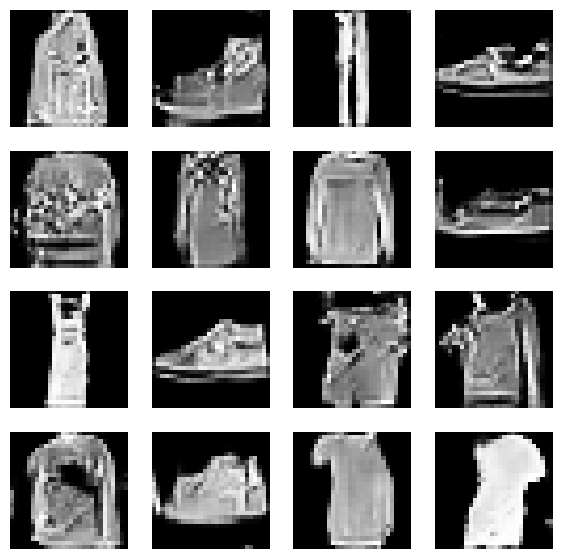

4/4 [==============================] - 0s 2ms/step
9500 == 판별자 손실:0.22132869064807892, 판별자정확도:0.9149999916553497, gan(생성자)  손실:2.7470552921295166
1/1 [==============================] - 0s 25ms/step


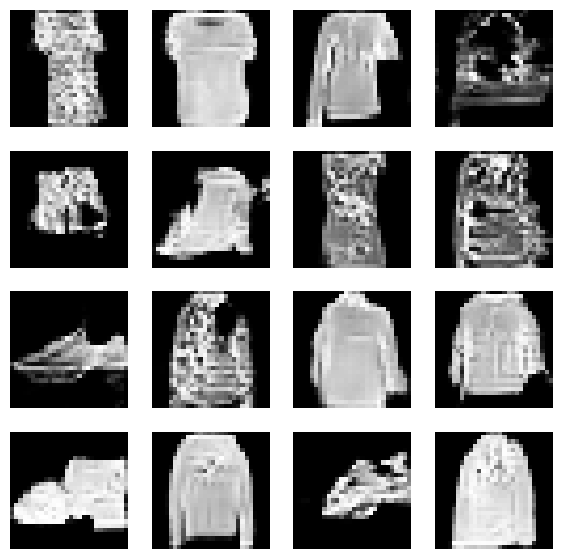

4/4 [==============================] - 0s 2ms/step
18.09661541382472 분


In [12]:
import time
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
iterations = 10000
batch_size=100
sample_interval=500
start = time.time()

train(X_train, iterations, batch_size, sample_interval)

end = time.time()
print((end-start)/60, '분')

In [ ]:
save_path = '/content/drive/MyDrive/saved_model/fashion_gan_generator'
generator.save(save_path)

# 이미지 생성

In [ ]:
import tensorflow as tf
save_path = '/content/drive/MyDrive/saved_model/fashion_gan_generator'
saved_generator = tf.keras.models.load_model(save_path)

In [ ]:
z = np.random.normal(0, 1, (6, 100))
pred = saved_generator.predict(z)

In [ ]:
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(pred[i].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.show()